## Computing the turnover correlations 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import data_utils as dt
import turnover_corr_utils as ut
import turnover_measures as ms
import stat_utils as st
import pickle

hiv_data_dir = '../data/hiv_msa/'
abr_data_dir = '../data/abr_fams/'

pd.options.mode.chained_assignment = None  # removing a useless warning

# Probability of a syn mutation for each codon
rand_syn_codon = ut.build_syn_prob_rand()

sns.set_theme(style="white")

In [3]:
def build_hiv_abr_info(pat):
    """
    It imports all the hiv and abr data and builds the dataframes used 
    for computing the turnover observables
    """
    
    # Data import
    hiv_times = dt.read_times(hiv_data_dir+'times.txt')[int(pat)-1]
    hiv_frame = dt.read_hiv_msa_fasta(hiv_data_dir+'pat'+pat+'_hiv_msa.fasta')
    fams = dt.import_fam_frame_pat(abr_data_dir, pat, keep_seq=True)
    abr_time_frame, abr_times = dt.build_fam_timeframe(fams, False)
    
    # Time alignment
    hiv_frame, abr_time_frame, overl_times = dt.align_times(hiv_frame, abr_time_frame, hiv_times, abr_times)
    
    # Hiv info
    hiv_cons0 = ut.build_consensus_sequence(hiv_frame[hiv_frame['time']==0].msa_seq)
    hiv_snp_frame = ut.build_time_snp_frame(hiv_frame, hiv_cons0)
    hiv_info = ms.hiv_info_container(hiv_frame, hiv_snp_frame, rand_syn_codon, overl_times)
    
    # Abr info
    abr_nseq = [len(abr_time_frame[abr_time_frame['time']==t]) for t in range(max(abr_time_frame['time']))]
    abr_time_frame['time_occ'] = np.ones(len(abr_time_frame))
    abr_time_frame = abr_time_frame.groupby('family').agg({'time_occ':sum, 'frequencies':list, 'counts':list, 
                                    'log+1_counts':list, 'time':list, 'seq_counts':list, 'seqs':list})
    sub_abr_time_frame = abr_time_frame[abr_time_frame['time_occ']>1]
    sub_abr_time_frame = sub_abr_time_frame.apply(dt.find_adj_times, axis=1)
    sub_abr_time_frame = sub_abr_time_frame[sub_abr_time_frame['n_adj_seqs']>0]
    abr_snps_dict = ut.build_abr_time_snp_frame(sub_abr_time_frame, len(overl_times))
    abr_info = ms.abr_info_container(abr_time_frame, sub_abr_time_frame, abr_snps_dict, 
                                     abr_nseq, rand_syn_codon, overl_times)
    
    return hiv_info, abr_info

In [97]:
hiv_measures_class = [
    ms.hiv_turnover_freq(),
    ms.hiv_turnover_count(),
    ms.hiv_turnover_synratio_freq(),
    ms.hiv_turnover_synratio_count(),
    ms.hiv_nseq(),
    ms.delta_times()
]
hiv_labels = [m.short_label() for m in hiv_measures_class]

abr_measures_class = [
    ms.abr_snp_turnover_freq(),
    ms.abr_snp_turnover_count(),
    ms.abr_lin_turnover_freq(),
    ms.abr_lin_turnover_count(),
    ms.abr_turnover_count_large(),
    ms.abr_turnover_count_small(),
    ms.abr_nseq(),
    ms.delta_times()
]
abr_labels = [m.short_label() for m in abr_measures_class]

In [98]:
hiv_measures, abr_measures = dict(), dict()

for pi in range(1,10): # Patient 10 is excluded since it has only 2 time points
    pat = str(pi)
    hiv_info, abr_info = build_hiv_abr_info(pat)
    hiv_measures[pat] = [m.run(hiv_info) for m in hiv_measures_class]
    abr_measures[pat] = [m.run(abr_info) for m in abr_measures_class]
    print('Patient ' + pat + ' completed')

Patient 1 completed
Patient 2 completed
Patient 3 completed
Patient 4 completed
Patient 5 completed
Patient 6 completed
Patient 7 completed
Patient 8 completed
Patient 9 completed


In [4]:
# Importing the measures if already saved, otherwise skip this box

f = open('out_data/abr_measures.pickle', 'rb')
abr_measures = pickle.load(f)
f.close()
f = open('out_data/abr_labels.pickle', 'rb')
abr_labels = pickle.load(f)
f.close()
f = open('out_data/hiv_measures.pickle', 'rb')
hiv_measures = pickle.load(f)
f.close()
f = open('out_data/hiv_labels.pickle', 'rb')
hiv_labels = pickle.load(f)
f.close()

In [99]:
stds = st.compute_corrcoef_std(19, R=5000)

In [100]:
hiv_rhos, hiv_pvals = st.compute_rescaled_corr(hiv_measures, hiv_measures, True, stds)
hiv_kss, hiv_kspval, hiv_av_rho = st.compute_KS_stat(hiv_rhos, True)

In [101]:
# Reordering according to paper notation

abr_labels = np.array(abr_labels)[[2,3,4,5,0,1,6,7]]
for p in abr_measures:
    abr_measures[p] = np.array(abr_measures[p])[[2,3,4,5,0,1,6,7]]

/home/andrea/Documents/Immunology/HIV_coevo/turnover_analysis/stat_utils.py:66: RuntimeWarning: divide by zero encountered in log10
  kspval_frame = pd.DataFrame(np.log10(kspval[1:,:-1]), index=m1_labels[1:], columns=m2_labels[:-1])


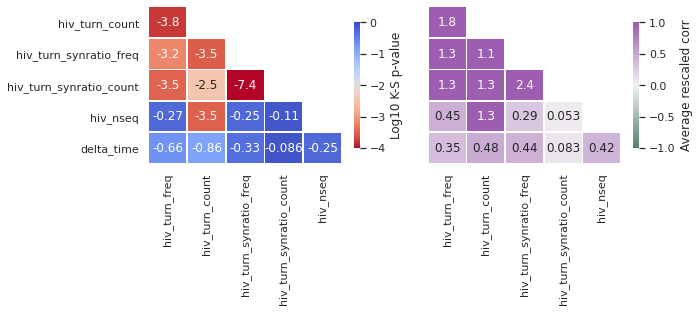

In [102]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4.5))
ax1,ax2 = st.plot_correlation_heatmap(ax1, ax2, hiv_kspval, hiv_av_rho, hiv_labels, hiv_labels, True)
plt.savefig('plots/hiv_ks_corr.svg', dpi=200)

In [103]:
abr_rhos, abr_pvals = st.compute_rescaled_corr(abr_measures, abr_measures, True, stds)
kss, abr_kspval, abr_av_rho = st.compute_KS_stat(abr_rhos, True)

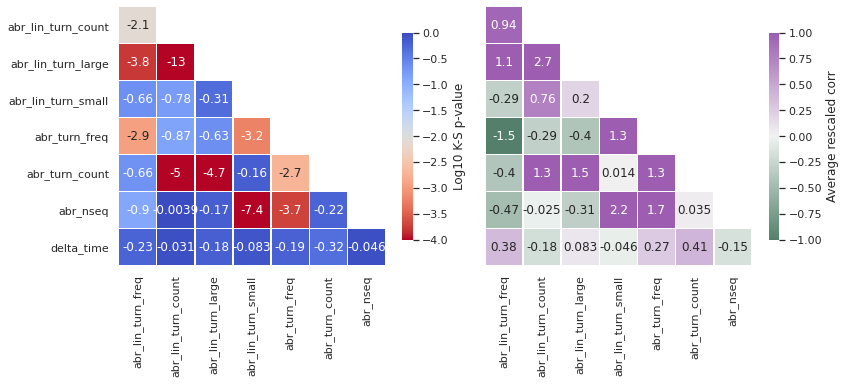

In [104]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5.5))
ax1,ax2 = st.plot_correlation_heatmap(ax1, ax2, abr_kspval, abr_av_rho, abr_labels, abr_labels, True)
plt.savefig('plots/abr_ks_corr.svg', dpi=200)

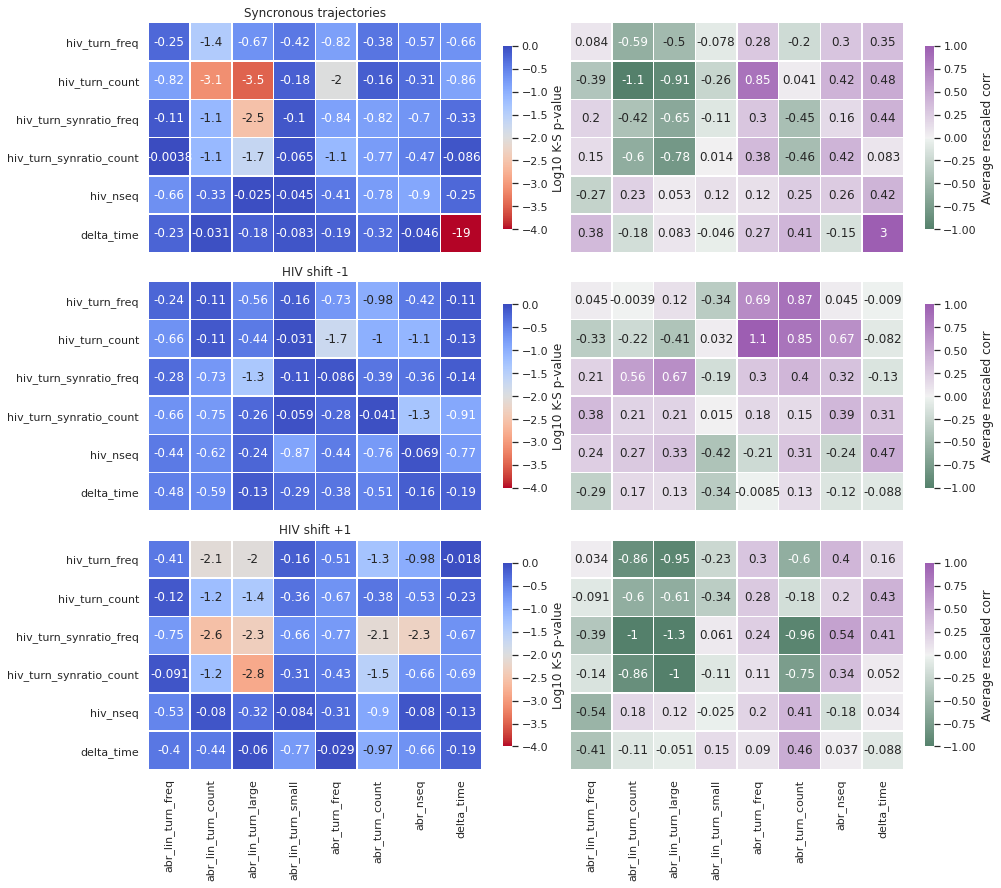

In [105]:
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, 0)
kss, kspval_sync, av_rho_sync = st.compute_KS_stat(rhos, False)
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, -1)
kss, kspval_hiv1, av_rho_hiv1 = st.compute_KS_stat(rhos, False)
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, 1)
kss, kspval_abr1, av_rho_abr1 = st.compute_KS_stat(rhos, False)

f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(14,12.5))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, kspval_sync, av_rho_sync, hiv_labels, abr_labels, False)
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_title('Syncronous trajectories')
ax3,ax4 = st.plot_correlation_heatmap(ax3,ax4, kspval_hiv1, av_rho_hiv1, hiv_labels, abr_labels, False)
ax3.set_xticks([])
ax4.set_xticks([])
ax3.set_title('HIV shift -1')
ax5,ax6 = st.plot_correlation_heatmap(ax5,ax6, kspval_abr1, av_rho_abr1, hiv_labels, abr_labels, False)
ax5.set_title('HIV shift +1')
plt.savefig('plots/ks_corr.svg', dpi=200)

### Exporting the measures

In [106]:
abr_f = open('out_data/abr_measures.pickle', 'wb')
pickle.dump(abr_measures, abr_f)
abr_f.close()
hiv_f = open('out_data/hiv_measures.pickle', 'wb')
pickle.dump(hiv_measures, hiv_f)
hiv_f.close()
abr_f = open('out_data/abr_labels.pickle', 'wb')
pickle.dump(abr_labels, abr_f)
abr_f.close()
hiv_f = open('out_data/hiv_labels.pickle', 'wb')
pickle.dump(hiv_labels, hiv_f)
hiv_f.close()

## Benjamini–Hochberg

In [13]:
sorted_pvals = np.sort(kspval_sync[:4,:6].flatten())
alpha = 0.05
m = len(sorted_pvals)
thresholds = alpha*(np.arange(m)+1)/m
print(np.sum(sorted_pvals < thresholds), 'significant values for sync traj')

3 significant values for sync traj


In [14]:
sorted_pvals = np.sort(kspval_abr1[:4,:6].flatten())
print(np.sum(sorted_pvals < thresholds), 'significant values for sync traj')

6 significant values for sync traj


## All correlations together

In [90]:
def rank(array, norm=True):
    temp = np.argsort(array)
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    if norm:
        ranks = ranks / (len(array)-1)
    return ranks

def compute_all_corr(corr_samples1, corr_samples2, is_self, temp_shift=0):
    k = list(corr_samples1.keys())[0]
    n_m1, n_m2 = len(corr_samples1[k]), len(corr_samples2[k])
    rhos = np.zeros((n_m1, n_m2))
    pvals = np.zeros((n_m1, n_m2))

    for i1 in range(n_m1):
        for i2 in range(n_m2):
            if not is_self or i1>i2:
                all_x, all_y = np.array([]), np.array([])
                for i in range(9):
                    pat = str(i+1)
                    m1, m2 = corr_samples1[pat][i1], corr_samples2[pat][i2]
                    if temp_shift >= 0:
                        all_x = np.append(all_x, rank(m1)[:len(m1)-temp_shift])
                        all_y = np.append(all_y, rank(m2)[temp_shift:])
                    else:
                        all_x = np.append(all_x, rank(m1)[abs(temp_shift):])
                        all_y = np.append(all_y, rank(m2)[:len(m1)-abs(temp_shift)])
                r,p = st.spearmanr(all_x,all_y)
                rhos[i1,i2] = r
                pvals[i1,i2] = p        
    return rhos, pvals

In [91]:
rhos_all_sync, pvals_all_sync = compute_all_corr(hiv_measures, abr_measures, False)

Text(0.5, 1.0, 'HIV shift +1')

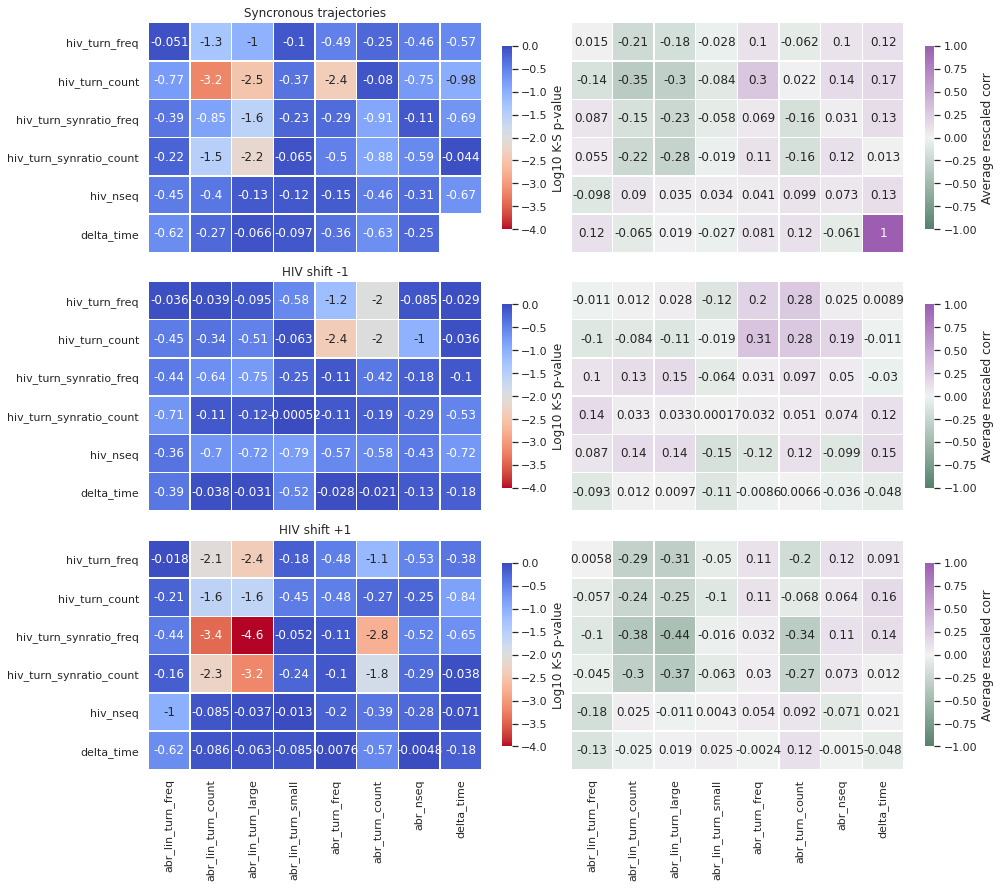

In [94]:
rhos_all_sync, pvals_all_sync = compute_all_corr(hiv_measures, abr_measures, False, 0)
rhos_all_hiv1, pvals_all_hiv1 = compute_all_corr(hiv_measures, abr_measures, False, -1)
rhos_all_abr1, pvals_all_abr1 = compute_all_corr(hiv_measures, abr_measures, False, 1)

f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(14,12.5))
ax1,ax2 = st.plot_correlation_heatmap(ax1,ax2, pvals_all_sync, rhos_all_sync, hiv_labels, abr_labels, False)
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_title('Syncronous trajectories')
ax3,ax4 = st.plot_correlation_heatmap(ax3,ax4, pvals_all_hiv1, rhos_all_hiv1, hiv_labels, abr_labels, False)
ax3.set_xticks([])
ax4.set_xticks([])
ax3.set_title('HIV shift -1')
ax5,ax6 = st.plot_correlation_heatmap(ax5,ax6, pvals_all_abr1, rhos_all_abr1, hiv_labels, abr_labels, False)
ax5.set_title('HIV shift +1')